In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import time 
import pandas as pd
from torch import nn

import progressbar
from progressbar import FormatLabel, Percentage, Bar, ETA


from data_loader import DataLoader
#import viewer functions
from dataViewer import plotTraj, animatePreview, animateLoc, animateTraj

import hdf5_utils as hd
import h5py
import os


%matplotlib notebook
%load_ext autoreload
%autoreload 2


np.random.seed(42)

In [2]:
def batch(arr1, arr2, n):
    """Yield successive n-sized chunks from l."""
    size = len(arr1)
    for i in range(0, size, n):
        yield arr1[i:min(i + n, size)], arr2[i:min(i + n, size)]
        
        

In [6]:
dtype = torch.float
#device = torch.device("cpu")
device = torch.device("cuda:0") # Uncomment this to run on GPU


number_nei = 7
shuffle = True
truth_with_vel=True
mode = "wrap"


# N is batch size (number of datasets); D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
D_in, H, D_out =  (number_nei+1)*4, 10, 2+truth_with_vel*2 #1550



learning_rate = 1e-3

iterations = 20

batch_size = 20



FPS = 16

BG = "Datasets/UG/ug.png"

PATH_1 = "Datasets/UG/UG-roh_nachkorrigiert/ug-100-045.txt"



PATH = "Datasets/AO/"
PATH2 = "data/HD5/"
fname = "ao-240-400_combine"

In [ ]:


#PATH_1 = "test.hd5"
#PATH_1 = "test.csv"

#ds = DataLoader(PATH + fname + ".txt")
#ds = DataLoader(PATH2 + fname + ".csv")
ds = DataLoader(PATH + fname + ".txt")

ds.load()

print("Persons: ", ds.data.p.max())
print("Frame maximum :", ds.data.f.max() )

f_x = ds.flip_x

augmentation = [f_x]
train, val, test = ds.get_train_data(number_nei, augmentation=augmentation,
                                     shuffle=shuffle,
                                     truth_with_vel=truth_with_vel,
                                     mode=mode)


N/A% (0 of 352) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

loaded 352 persons
Persons:  352
Frame maximum : 1128


 47% (166 of 352) |##########            | Elapsed Time: 0:01:18 ETA:   0:02:19

# Store and Load train and testdata

In [ ]:

sufix = "{}_{}_{}_{}".format(number_nei,shuffle, truth_with_vel, mode)

In [ ]:
# hdf 5 dump


database = h5py.File(PATH2+fname+sufix+'.h5', 'w')

hd.write_attrs(database, {'creator':'zehndiii',       # write general attributes
                          'date':time.ctime(),
                          'neighbors':number_nei,
                          'augmentation':str(augmentation),
                          'shuffle':shuffle,
                          'truth_with_vel':truth_with_vel,
                          'mode':mode
                         })

train_h = database.create_group('/train')
train_h.create_dataset( name='input',shape=train[0].shape, 
                                     dtype=train[0].dtype,
                                     data=train[0], compression="lzf" )
train_h.create_dataset( name='truth',shape=train[1].shape, 
                                     dtype=train[1].dtype,
                                     data=train[1], compression="lzf" )
val_h = database.create_group('/val')
val_h.create_dataset( name='input',shape=val[0].shape, 
                                     dtype=val[0].dtype,
                                     data=val[0], compression="lzf" )
val_h.create_dataset( name='truth',shape=val[1].shape, 
                                     dtype=val[1].dtype,
                                     data=val[1], compression="lzf" )
test_h = database.create_group('/test')
test_h.create_dataset( name='input',shape=test[0].shape, 
                                     dtype=test[0].dtype,
                                     data=test[0], compression="lzf" )
test_h.create_dataset( name='truth',shape=test[1].shape, 
                                     dtype=test[1].dtype,
                                     data=test[1], compression="lzf" )

database.close()
print("Training data saved to : {}".format(PATH2+fname+sufix+'.h5'))

In [ ]:
hd.print_stats(PATH2+fname+sufix+'.h5')

In [ ]:
file_name = PATH2+fname+sufix+'.h5'

database = h5py.File(file_name, 'r')                  # open db
        
atrs = hd.load_attrs(database)                        # print attrs if debug


number_nei = atrs['neighbors']
shuffle = atrs['shuffle']
truth_with_vel = atrs['truth_with_vel']
mode = atrs['mode']


train = (database.get('train/input').value, database.get('train/truth').value )
val = (database.get('val/input').value, database.get('val/truth').value )
test = (database.get('test/input').value, database.get('test/truth').value )

database.close()

# Format training data as tensors

In [47]:
t_input, t_truth = train
v_input, v_truth = val

In [48]:
t_i = torch.from_numpy(t_input).to(device)
t_t = torch.from_numpy(t_truth).to(device)

v_i = torch.from_numpy(v_input).to(device)
v_t = torch.from_numpy(v_truth).to(device)


# Define Model

In [58]:

hidden_layer = [32, 32, 64, 128, 128, 40]

# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNet, self).__init__()
        self.fc_in = nn.Linear(input_size, hidden_size[0]) 
        
        #self.fc_hidden = []
        #for i in range(len(hidden_size)-1):
        self.fc_hidden_1 = nn.Linear(hidden_size[0], hidden_size[1])
        self.fc_hidden_2 = nn.Linear(hidden_size[1], hidden_size[2])
        self.fc_hidden_3 = nn.Linear(hidden_size[2], hidden_size[3])
        
        self.fc_hidden_4 = nn.Linear(hidden_size[3], hidden_size[4])
        self.fc_hidden_5 = nn.Linear(hidden_size[4], hidden_size[5])

        
        self.fc_out = nn.Linear(hidden_size[-1], output_size)
        self.relu = nn.ReLU()
    
    def forward(self, x):
     
        out = self.relu(self.fc_in(x))
        
        #for i in range(len(self.fc_hidden)):
        #    out = self.relu(self.fc_hidden[i](out))
        
        out = self.relu(self.fc_hidden_1(out))
        out = self.relu(self.fc_hidden_2(out))
        out = self.relu(self.fc_hidden_3(out))
        out = self.relu(self.fc_hidden_4(out))
        out = self.relu(self.fc_hidden_5(out))
        
        
        out = self.fc_out(out)
        return out

model = NeuralNet(D_in, hidden_layer, D_out).to(device)



In [59]:
#choose loss function - can be played around with
loss_fn = torch.nn.MSELoss(reduction='mean')


optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


In [60]:

d_len = t_i.shape[0]


pbar = progressbar.ProgressBar(max_value=iterations)

widgets = [FormatLabel(''), ' ', Percentage(), ' ', Bar(), ' ', ETA()]
pbar = progressbar.ProgressBar(widgets=widgets, maxval=iterations*d_len)
pbar.start()

training_loss = []
validation_loss = [0.0]

for t in range(iterations):
    
    # Train on Batches
    
    p = np.random.permutation(len(t_i))
    t_i = t_i[p]
    t_t = t_t[p]
    
    for  y, (t_i_b, t_t_b) in  enumerate(batch(t_i, t_t, batch_size)):
        y_pred = model(t_i_b)


        """if t==1000:
            lr = 1e-5
            #optimizer.lr = lr
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
        if t==4000:
            lr = 1e-6
            #optimizer.lr = lr
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr"""

       
        loss = loss_fn(y_pred, t_t_b)

        model.zero_grad()
       
        loss.backward()

        optimizer.step()
        
        widgets[0] = FormatLabel('loss(t/v) : {:.4} / {:.4} | lr={}'.format(loss.item(),
                                                                            validation_loss[-1],
                                                                            optimizer.param_groups[0]['lr']))
        pbar.update(t*d_len+y*batch_size)
        
        if y%10==9:
            training_loss += [loss.cpu().detach().numpy()]
    
    # Test on validation
    
    loss = []
    for v_i_b, v_t_b in batch(v_i, v_t, batch_size):
        y_pred = model(v_i_b)
        loss += [loss_fn(y_pred, v_t_b).cpu().detach().numpy()]
    validation_loss.append( np.array(loss).mean() )
    
    scheduler.step()
        

pbar.finish()

train_loss = np.array(training_loss)
val_loss = np.array(validation_loss[1:])






loss(t/v) : 1.016 / 23.35 | lr=0.0001 100% |###################| Time:  0:03:44


<IPython.core.display.Javascript object>


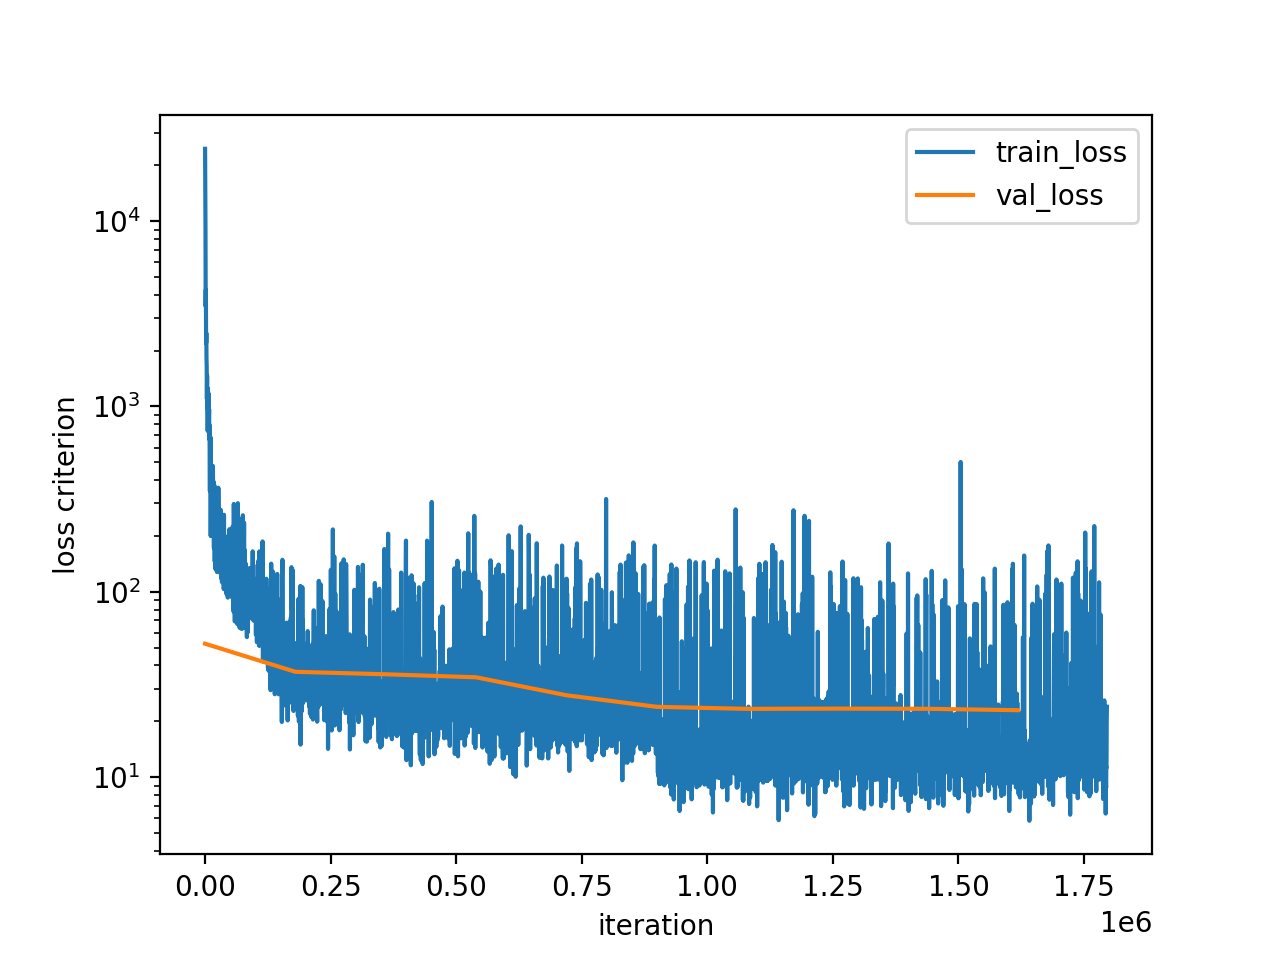

10
4490


In [61]:
plt.figure()
plt.semilogy(np.arange(len(train_loss))*10*batch_size, train_loss, label="train_loss")
plt.semilogy(np.arange(len(val_loss))*d_len, val_loss, label="val_loss" )
plt.xlabel("iteration")
plt.ylabel("loss criterion")
plt.legend()
plt.show()
print(len(val_loss))
print(len(train_loss))

In [62]:
model.eval()

NeuralNet(
  (fc_in): Linear(in_features=32, out_features=32, bias=True)
  (fc_hidden_1): Linear(in_features=32, out_features=32, bias=True)
  (fc_hidden_2): Linear(in_features=32, out_features=64, bias=True)
  (fc_hidden_3): Linear(in_features=64, out_features=128, bias=True)
  (fc_hidden_4): Linear(in_features=128, out_features=128, bias=True)
  (fc_hidden_5): Linear(in_features=128, out_features=40, bias=True)
  (fc_out): Linear(in_features=40, out_features=4, bias=True)
  (relu): ReLU()
)

# Save/ Load model

In [63]:
torch.save(model.state_dict(), "data/model/model_paper.dat")

In [27]:

load_path = "data/model/model_paper.dat"

model = NeuralNet(D_in, hidden_layer, D_out).to(device)

model.load_state_dict(torch.load(load_path))
model.eval()


NeuralNet(
  (fc_in): Linear(in_features=32, out_features=32, bias=True)
  (fc_hidden_1): Linear(in_features=32, out_features=32, bias=True)
  (fc_hidden_2): Linear(in_features=32, out_features=64, bias=True)
  (fc_hidden_3): Linear(in_features=64, out_features=128, bias=True)
  (fc_hidden_4): Linear(in_features=128, out_features=128, bias=True)
  (fc_hidden_5): Linear(in_features=128, out_features=40, bias=True)
  (fc_out): Linear(in_features=40, out_features=4, bias=True)
  (relu): ReLU()
)

In [64]:
from torchviz import make_dot, make_dot_from_trace

make_dot(model(t_i_b[0]), params=dict(model.named_parameters()))

ExecutableNotFound: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH

In [67]:
import multiprocessing


class Agent(multiprocessing.Process):
    def __init__(self, model, pos_vel_0, id=100, frame_0=0, T=16, truth_with_vel=False, device="cpu"):
        
        
        self.id = id
        
        self.model = model
        self.device = device
        self.truth_with_vel = truth_with_vel
        
        if self.device.type.startswith("cuda"):
            self.model.cuda()
        
        #print(pos_vel_0)
        self.pos_vel_0 = pos_vel_0.copy()
        self.frame_c = frame_0
        
        self.T = T
        
        # position and velocity data
        self.frames = [frame_0]
        self.traj = [pos_vel_0]
                
    @property 
    def pos(self):
        return self.traj[-1][ :2]
    
    @property
    def vel(self):
        return self.traj[-1][ 2:]
    
    def run(self, neighbors):
        return self.step(neighbors)
    
    def step(self, neighbors):
        
        with torch.no_grad():
            x_sim = torch.from_numpy(neighbors).to(self.device)

            y_sim = model(x_sim.float())
            
        if self.truth_with_vel:
            v_sim = y_sim[2:]
            y_sim = y_sim[:2]
        else:
            v_sim = (y_sim[:2]-x_sim[:2])/self.T
        
        self.traj.append( np.concatenate( (y_sim.cpu().detach().numpy(), v_sim.cpu().detach().numpy()) ) )
        self.frame_c +=1
        self.frames.append(self.frame_c)
        
        return self.traj[-1]
        

In [100]:
class Engine():
    def __init__(self, ds, agents=[], nn=10, stop_agent=False, mode="wraps", exportpath="sim.csv"):
        
        self.ds = DataLoader(exportpath)
        self.ds.copy(ds)
        
        self.agents = agents
        
        self.nn = nn
        self.mode = mode
        self.stop_agent = stop_agent
        
        self.cur_f = 0
        
    def step(self, ):
        
        in_frame, _ = self.ds.frame(self.cur_f)
        for a in self.agents:
            if a.pos[0]>500 and self.stop_agent:
                continue
            
            if a.id not in in_frame :
                continue
            _, pos_vel = self.ds.frame_nn(self.cur_f, a.id, nn=self.nn, use_roi=False, mode=self.mode)
            
            n_pos_vel = a.step(pos_vel.copy().ravel()).copy()
            #print("===STEP===")
            #print(n_pos_vel)
            #print(a.traj[-1])
            
            n_pos_vel [[0, 1]] = n_pos_vel [[1, 0]]
           
            
            # TODO write to ds
            entry = np.concatenate( ([a.id], [self.cur_f+1], n_pos_vel[:2], [0], n_pos_vel[2:] ) )
            
            if len(self.ds.data[(self.ds.data["p"]==a.id) & (self.ds.data["f"]==self.cur_f+1)]):
                self.ds.data[(self.ds.data["p"]==a.id) & (self.ds.data["f"]==self.cur_f+1)] = [entry]
            else:
                self.ds.data = self.ds.data.append(pd.DataFrame([entry],
                                                                columns=list(self.ds.data)),
                                                               ignore_index=True)    
                
            #print(self.ds.data[(self.ds.data["p"]==a.id) & (self.ds.data["f"]==self.cur_f+1)])
            
            #_, traj = sim.ds.person(test_person+100)
            #print(traj[:5])

        self.cur_f += 1
        
    
    def run(self, start_f, stop_f, ):
        self.cur_f = start_f
        print("sim from : {} to {}".format(start_f, stop_f))
        widgets = [FormatLabel(''), ' ', Percentage(), ' ', Bar(), ' ', ETA()]
        pbar = progressbar.ProgressBar(widgets=widgets, maxval=stop_f)
        pbar.start()
        
        for  a in self.agents:

            pos = a.pos_vel_0[:2]
            
            entry = np.concatenate( ([a.id],  [a.frame_c], np.flip(pos) , [0],  a.pos_vel_0[2:]) )
            
            if len(self.ds.data[(self.ds.data["p"]==a.id) & (self.ds.data["f"]==a.frame_c)]):
                self.ds.data[(self.ds.data["p"]==a.id) & (self.ds.data["f"]==a.frame_c)] = [entry]
            else:
                self.ds.data = self.ds.data.append(pd.DataFrame([entry],
                                                                columns=list(self.ds.data)),
                                                               ignore_index=True)
        
        
        while self.cur_f < stop_f:
            self.step()
            #print("===RUN===")
            #print(self.agents[-1].traj[-1])
            #print(self.ds.data[(self.ds.data["p"]==self.agents[-1].id) & (self.ds.data["f"]==self.cur_f)])
            widgets[0] = FormatLabel('frame: {:4}'.format(self.cur_f))
            pbar.update(self.cur_f)
        
        pbar.finish()


    
    def save(self, ):
        pass
        

In [101]:

test_person = id

da = DataLoader(None)

da.copy(ds)

frames_o, pos_vel_o = da.person(test_person, )
#frames, pos_vel = da.grab_roi(frames_o, pos_vel_o, x_pad=50)

da.remove_person(test_person)

print(pos_vel_o.shape)

agent = Agent(model, pos_vel_0=pos_vel_o[0], frame_0=frames_o[0], truth_with_vel=truth_with_vel,
              device=device, id=1000+test_person )



print(agent.id )
print(pos_vel_o[0])


sim = Engine(da, agents=[agent], nn=number_nei, mode=mode, )

sim.run(frames_o[0],700 )#frames_o[-1], )



frame:   45   6% |##                                           | ETA:   0:00:02

(264, 4)
1020
[-345.37699999999995 -83.2863 5.8400000000001455 0.8143999999999778]
sim from : 30 to 700


frame:  700 100% |#############################################| Time:  0:00:07


<IPython.core.display.Javascript object>


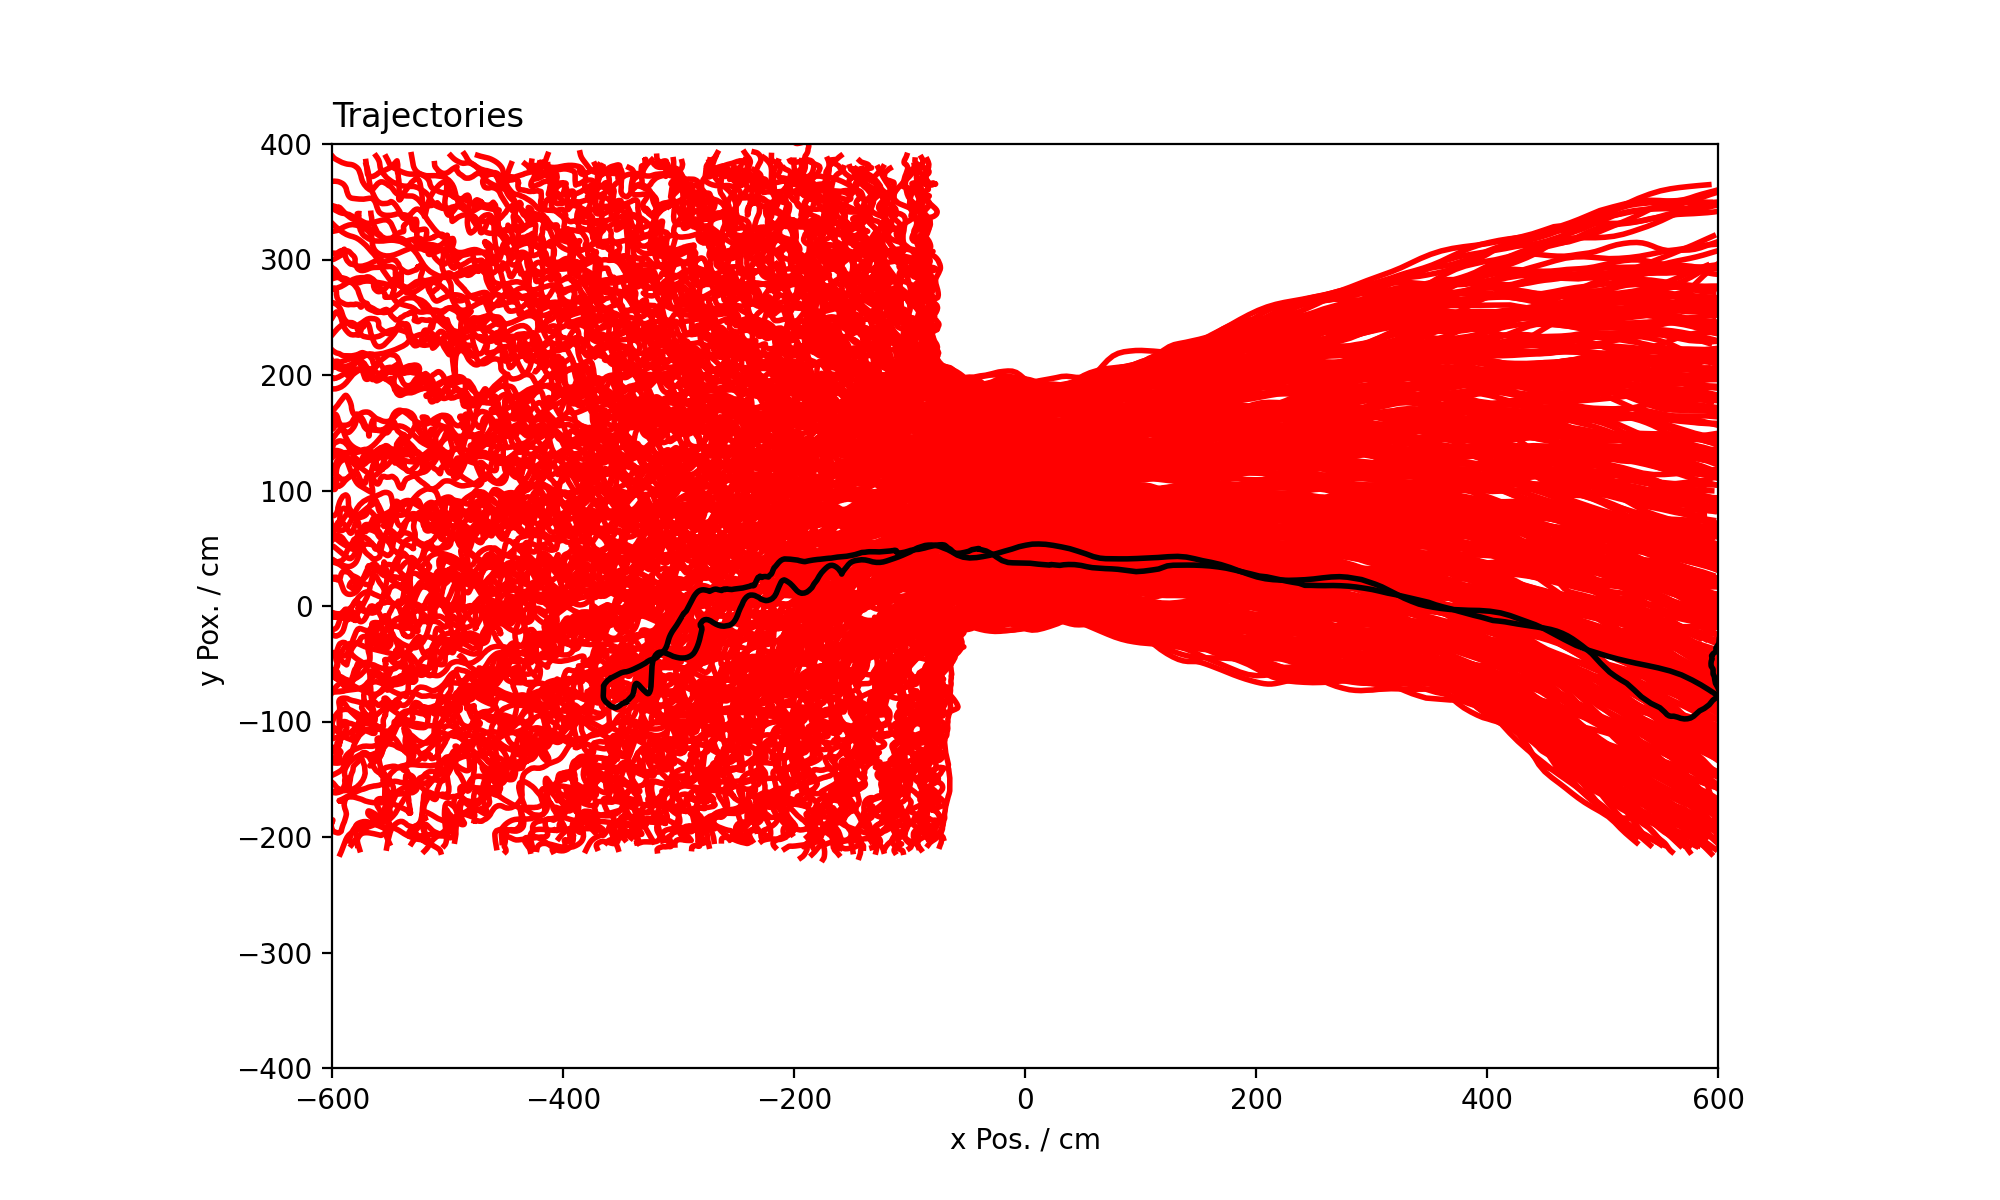

In [102]:

dp = DataLoader(None)
dp.copy(sim.ds)
dp.append_person(test_person, frames_o, pos_vel_o[:,:2], vel=pos_vel_o[:,2:] )

plotTraj(dp,  boundaries=[-600, 600, -400, 400],
         people=None,
         ai=[test_person, 1000+test_person],
         legend=False,
         title="Trajectories",
         path="trajectories.png",
         save=False)

<IPython.core.display.Javascript object>


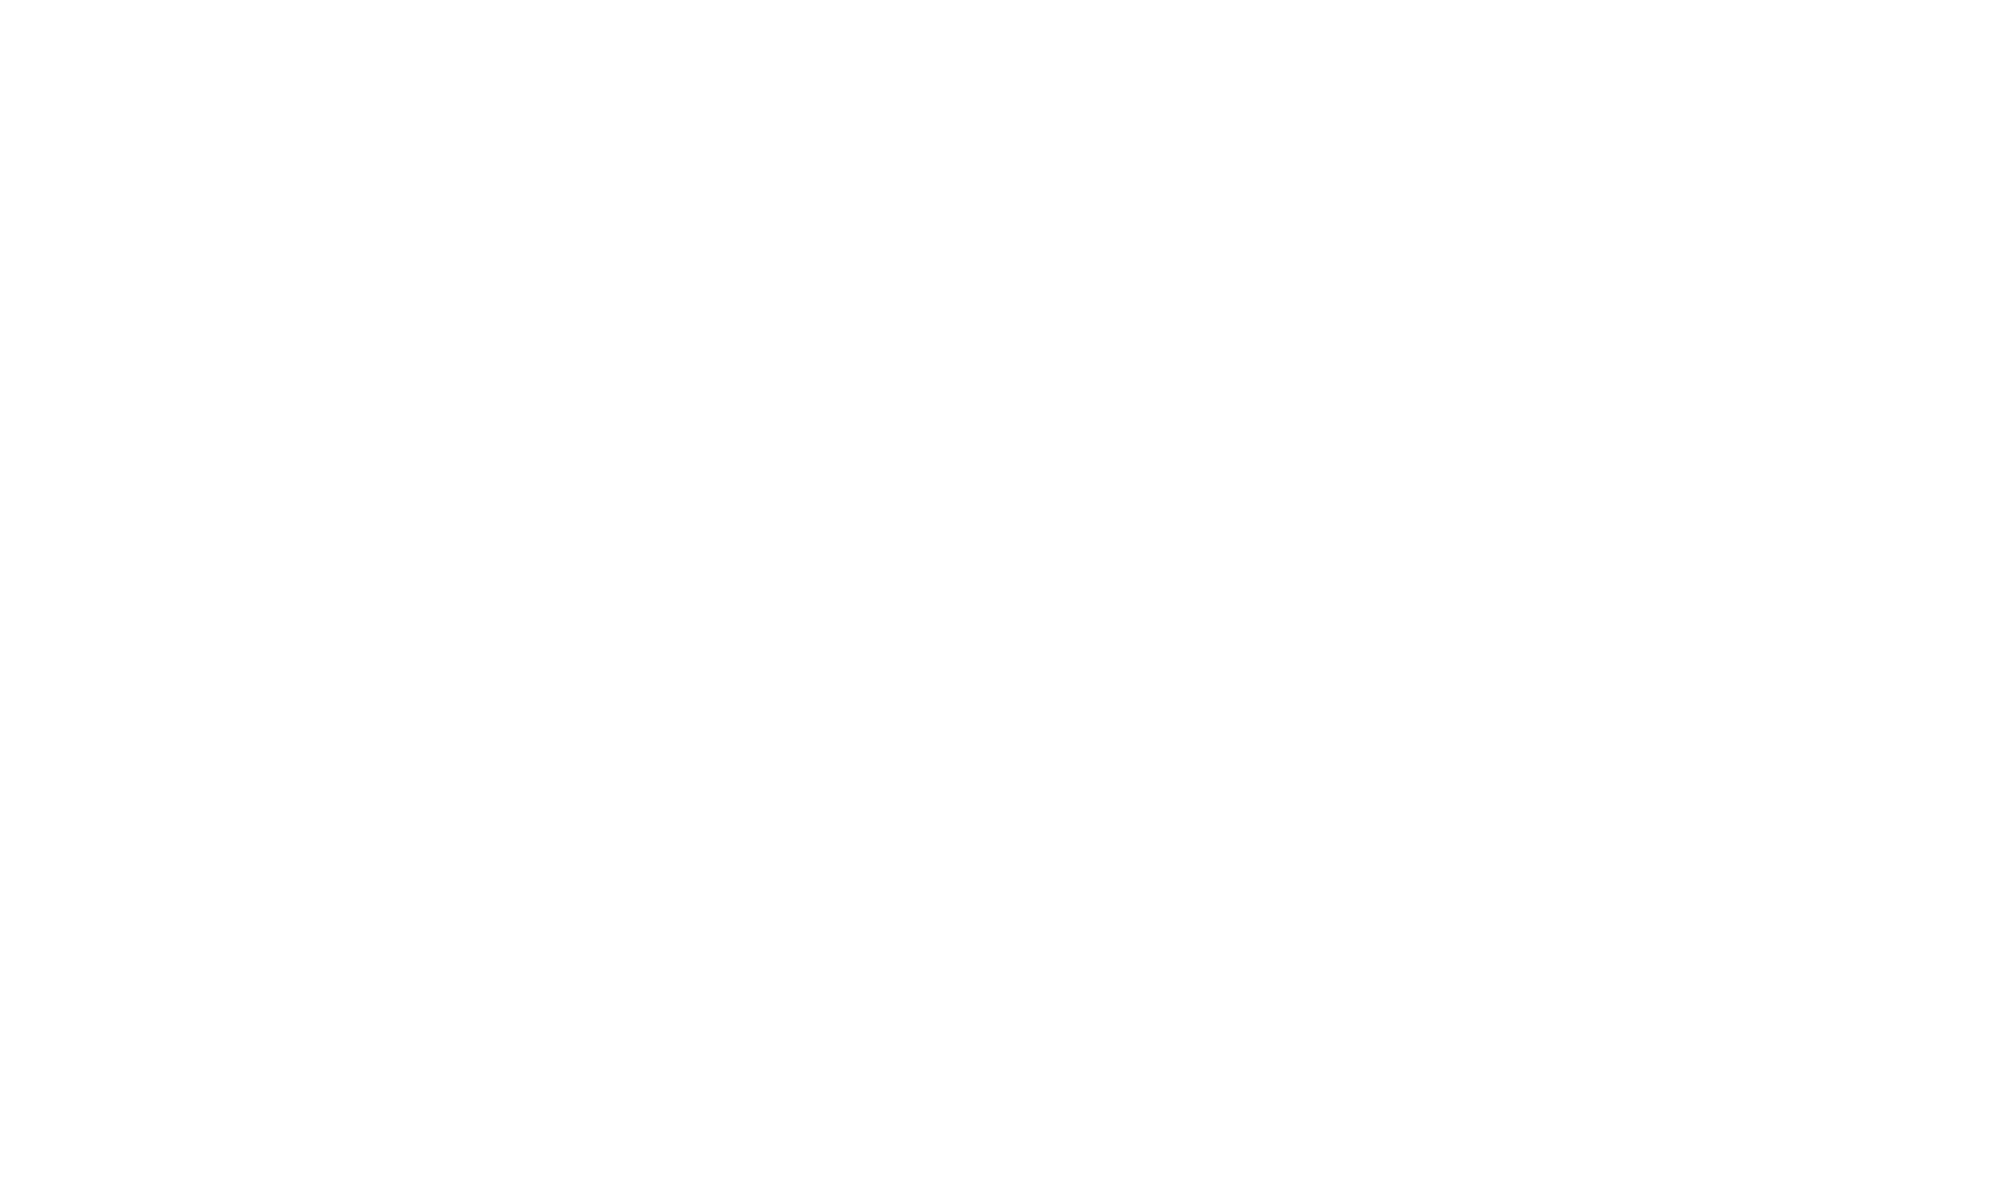

In [77]:
ani = animateLoc(dp, frame_start=frames[offset], frame_stop=frames[end],ai=[1000+test_person],
             boundaries=[-800, 600, -200, 400], step=1, fps=16, title="ululululu", save=False)
display(ani)

In [ ]:
animatePreview(dp, boundaries=[-600, 600, -250, 150], step=5)

In [ ]:
ani = animateTraj(dp, frame_start=frames[0], frame_stop=frames[-1], boundaries=[-600, 600, -250, 150], step=1, fps=16, title="Trajectory Animation")
ani

# Multi agent simulation

frame:    9   1% |                                             | ETA:   0:00:05

sim from : 0 to 700


frame:  700 100% |#############################################| Time:  0:00:34


<IPython.core.display.Javascript object>


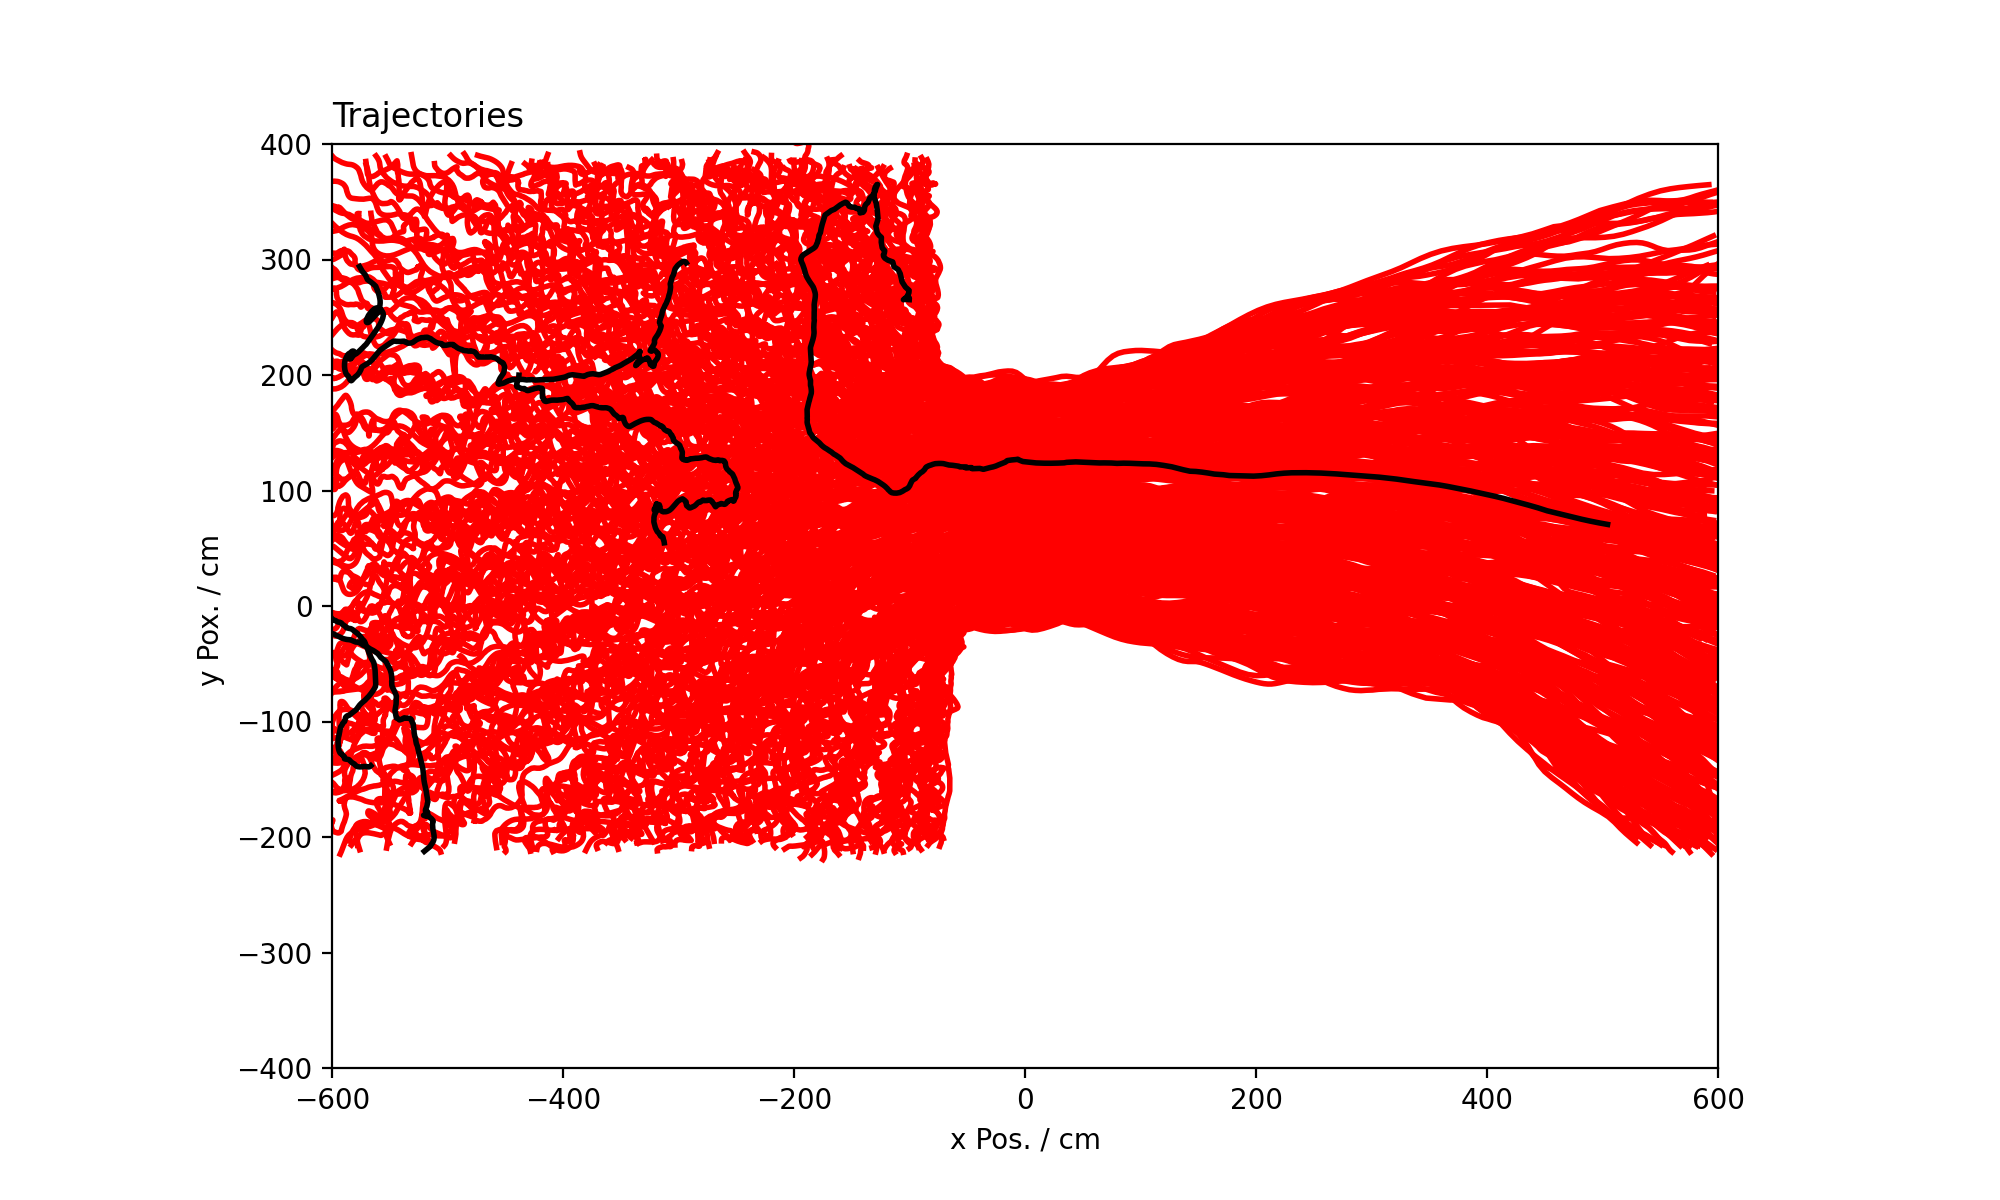

In [110]:
agents_id = np.array([10, 50, 90, 120, 160, 200])

#agents_id, _ = ds.frame(200)

da = DataLoader(None)

da.copy(ds)

agents = []

for test_person in agents_id:
    frames_o, pos_vel_o = da.person(test_person, )


    da.remove_person(test_person)

    agents += [Agent(model, pos_vel_0=pos_vel_o[0], frame_0=frames_o[0], truth_with_vel=truth_with_vel,
              device=device, id=1000+test_person )]


sim = Engine(da, agents=agents, nn=number_nei, mode=mode, stop_agent=True)

sim.run(0,700 )#frames_o[-1], )



dp = DataLoader(None)
dp.copy(sim.ds)
#dp.append_person(test_person, frames_o, pos_vel_o[:,:2], vel=pos_vel_o[:,2:] )


plotTraj(dp,  boundaries=[-600, 600, -400, 400],
         people=None,
         ai=agents_id+1000,
         legend=False,
         title="Trajectories",
         path="trajectories.png",
         save=False)

<IPython.core.display.Javascript object>


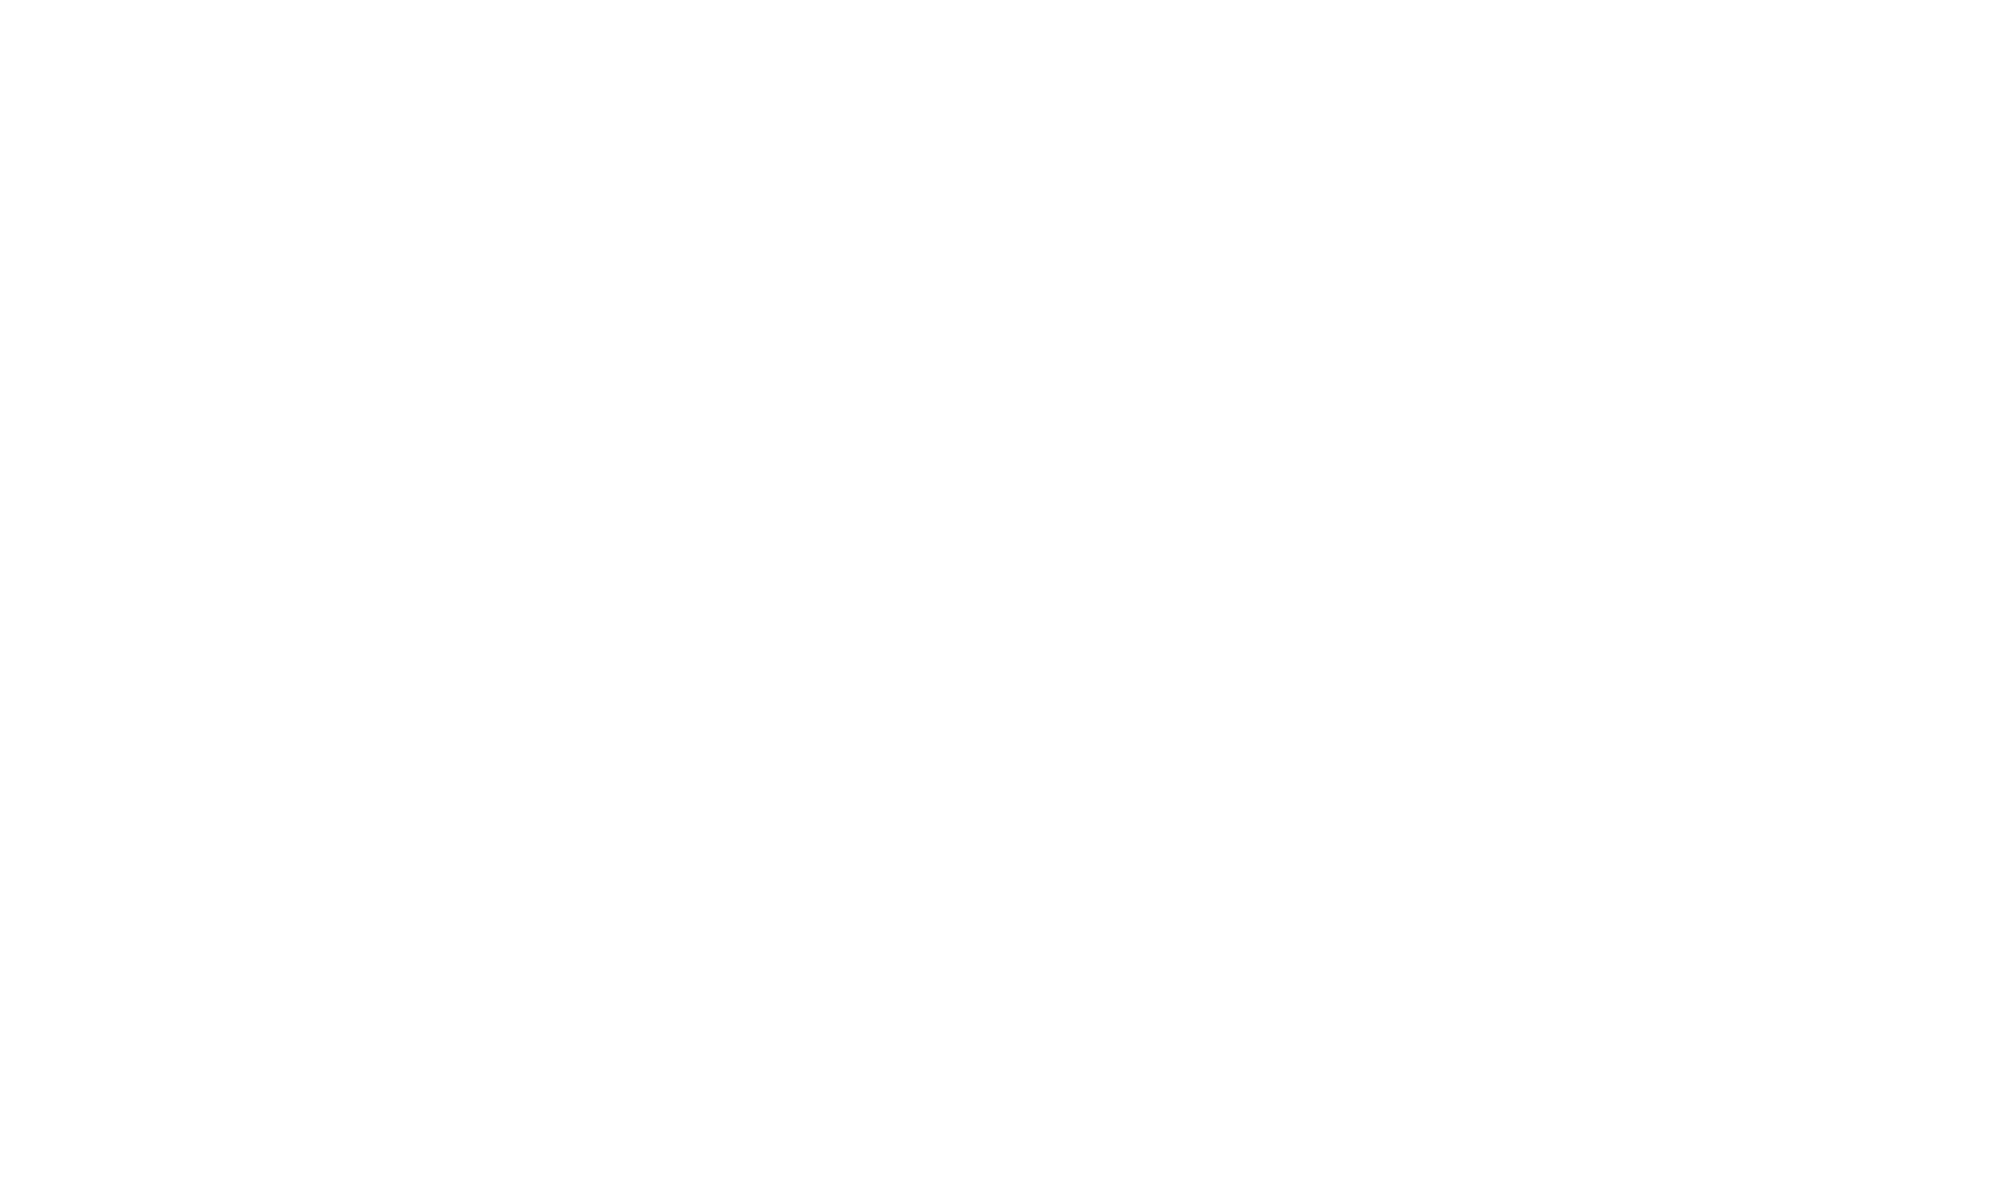

In [104]:
ani = animateLoc(dp, frame_start=frames[offset], frame_stop=frames[end],ai=agents_id+1000,
             boundaries=[-800, 600, -200, 400], step=1, fps=16, title="ululululu", save=False)
display(ani)

In [105]:
len(agents_id)

225

In [109]:
pers, _ = dp.frame(200)
pers

array([1251., 1001., 1002., 1003., 1004., 1005., 1006., 1007., 1008.,
       1009., 1010., 1011., 1013., 1014., 1015., 1016., 1017., 1018.,
       1019., 1020., 1021., 1023., 1024., 1025., 1026., 1027., 1029.,
       1030., 1031., 1032., 1034., 1035., 1036., 1037., 1040., 1042.,
       1045., 1046., 1049., 1050., 1051., 1052., 1053., 1055., 1057.,
       1060., 1061., 1062., 1064., 1065., 1066., 1068., 1070., 1071.,
       1073., 1075., 1077., 1078., 1079., 1081., 1083., 1085., 1086.,
       1087., 1088., 1089., 1092., 1093., 1094., 1095., 1096., 1099.,
       1100., 1101., 1102., 1103., 1104., 1105., 1106., 1107., 1108.,
       1111., 1112., 1113., 1114., 1115., 1116., 1117., 1118., 1120.,
       1121., 1122., 1123., 1124., 1125., 1127., 1128., 1129., 1130.,
       1132., 1133., 1134., 1135., 1136., 1137., 1138., 1139., 1140.,
       1141., 1142., 1143., 1144., 1145., 1146., 1147., 1148., 1149.,
       1150., 1151., 1152., 1153., 1154., 1155., 1156., 1157., 1158.,
       1159., 1160.,

agent
[[-345.37699999999995 -83.2863 5.8400000000001455 0.8143999999999778]
 [-346.3029479980469 -83.6595687866211 3.972341775894165
  2.4344308376312256]
 [-347.3938903808594 -84.01055145263672 2.1726179122924805
  3.9459428787231445]
 [-348.42681884765625 -84.46317291259766 0.567952036857605
  5.465214252471924]
 [-349.36395263671875 -85.02025604248047 -0.916903018951416
  6.897802352905273]]
[661.4725      4.6681385]
dataset
[[-345.37699999999995 -83.2863 5.8400000000001455 0.8143999999999778]
 [-346.3029479980469 -83.6595687866211 3.972341775894165
  2.4344308376312256]
 [-347.3938903808594 -84.01055145263672 2.1726179122924805
  3.9459428787231445]
 [-348.42681884765625 -84.46317291259766 0.567952036857605
  5.465214252471924]
 [-349.36395263671875 -85.02025604248047 -0.916903018951416
  6.897802352905273]]


<IPython.core.display.Javascript object>


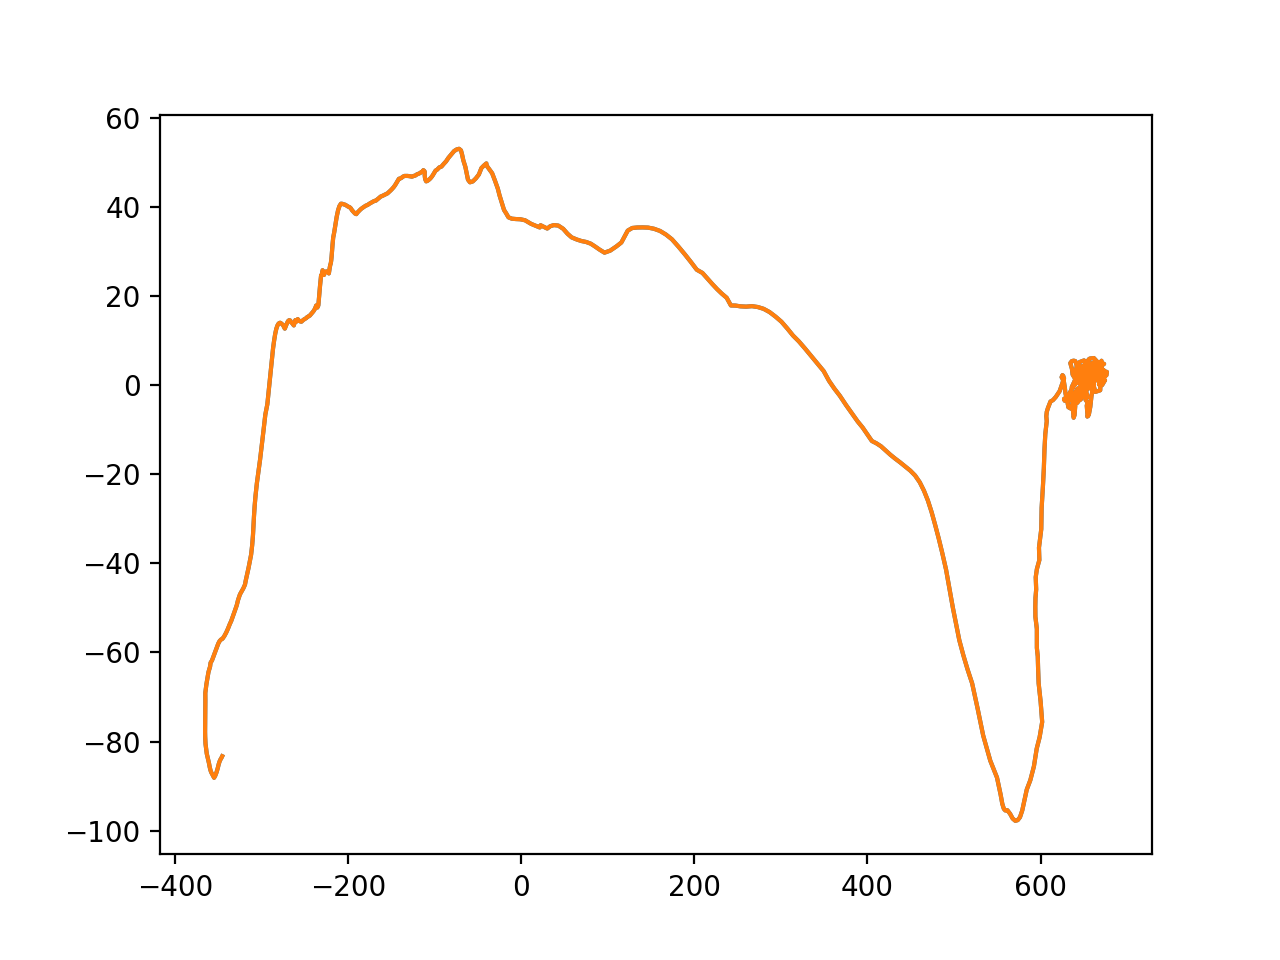

30.0


'\n[[-342.531 -3.04867 -1.024000000000342 4.645119999999999]\n [-332.4825439453125 -3.1519365310668945 0.6280288696289062\n  -0.006454154849052429]\n [-322.0271301269531 -2.130854606628418 0.6534633636474609\n  0.06381762027740479]\n [-312.77081298828125 -3.785721778869629 0.5785198211669922\n  -0.10342919826507568]\n [-302.70819091796875 -2.7985124588012695 0.6289138793945312\n  0.06170058250427246]]\n\n'

In [74]:
ai = sim.agents[0]
tr = np.vstack( ai.traj )

print("agent")
print(tr[:5])

print(ai.pos)
frames, traj = sim.ds.person(test_person+1000)

print("dataset")
#print(frames[:])
print(traj[:5])

plt.figure()

offset = 0
end = -1
plt.plot(tr[:,0], tr[:,1]) 



plt.plot(traj[offset: end,0], traj[offset:end,1])

print(frames[offset])

#plt.xlim([-600, 600])
#plt.ylim([-150, 150])

plt.show()

"""
[[-342.531 -3.04867 -1.024000000000342 4.645119999999999]
 [-332.4825439453125 -3.1519365310668945 0.6280288696289062
  -0.006454154849052429]
 [-322.0271301269531 -2.130854606628418 0.6534633636474609
  0.06381762027740479]
 [-312.77081298828125 -3.785721778869629 0.5785198211669922
  -0.10342919826507568]
 [-302.70819091796875 -2.7985124588012695 0.6289138793945312
  0.06170058250427246]]

"""

In [ ]:

#define network



model = torch.nn.Sequential(
    
    torch.nn.Linear(D_in, 50), 
    torch.nn.ReLU(),
    torch.nn.Linear(50, 10),
    
    torch.nn.ReLU(),
    torch.nn.Linear(10, 50),
    torch.nn.ReLU(),
    
    torch.nn.Dropout(p=0.1),
    
    torch.nn.Linear(50, 30),
    
    torch.nn.ReLU(),
    
    torch.nn.Dropout(p=0.1),
    
    torch.nn.Linear(30, D_out), 
)



hidden_size = 28#50
hidden_size2 = 20
hidden_size3 = 10#50
hidden_size4 = 10


# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_size2, hidden_size3, hidden_size4, output_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, hidden_size2) 
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, hidden_size4)
        self.fc5 = nn.Linear(hidden_size4, output_size)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(0.1)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
         
        out = self.drop( self.fc3(out) )
        
        out = self.relu(out)
        out = self.fc4(out)
        out = self.relu(out)
        out = self.fc5(out)
        return out

model = NeuralNet(D_in, hidden_size, hidden_size2, hidden_size3, hidden_size4,D_out).to(device)


#if device.type.startswith("cuda"):
#    model.cuda()

In [ ]:
class Model(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.model = torch.nn.ModuleDict({
            'lstm': torch.nn.LSTM(
                input_size=D_in,    # 45, see the data definition
                hidden_size=l_o,  # Can vary
            ),
            'linear1': torch.nn.Linear(
                in_features=l_o,
                out_features=D_out)
        })
        
    def forward(self, x):

        # From [batches, seqs, seq len, features]
        # to [seq len, batch data, features]
        x = x.view(x_seq_len, -1, x_features)
       
        # Data is fed to the LSTM
        out, _ = self.model['lstm'](x)
        

        # From [seq len, batch, num_directions * hidden_size]
        # to [batches, seqs, seq_len,prediction]
        out = out.view(x_batches, x_seqs, x_seq_len, -1)
      

        # Data is fed to the Linear layer
        out = self.model['linear1'](out)
       

        # The prediction utilizing the whole sequence is the last one
        y_pred = out[:, :, -1].unsqueeze(-1)
       

        return y_pred


model = Model()